In [1]:
#%env XLA_PYTHON_CLIENT_PREALLOCATE=false
%env XLA_PYTHON_CLIENT_ALLOCATOR=platform

env: XLA_PYTHON_CLIENT_ALLOCATOR=platform


In [2]:
import os
import sys
import jax


import synax
import importlib
importlib.reload(synax)

import jax.numpy as jnp
import interpax
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import scipy.constants as const

In [3]:
#for debug
def reload_package(package):
    importlib.reload(package)
    for attribute_name in dir(package):
        attribute = getattr(package, attribute_name)
        if type(attribute) == type(package):
            importlib.reload(attribute)

In [32]:
reload_package(synax)

In [11]:
nx,ny,nz = 256,256,64

xs,step = jnp.linspace(-20,20,nx,endpoint=False,retstep=True)
xs = xs + step*0.5

ys,step = jnp.linspace(-20,20,ny,endpoint=False,retstep=True)
ys = ys + step*0.5

zs,step = jnp.linspace(-5,5,nz,endpoint=False,retstep=True)
zs = zs + step*0.5

coords = jnp.meshgrid(xs,ys,zs,indexing='ij')

In [3]:
jf12_params = {"b_arm_1":0.1,
               "b_arm_2":3.0,
               "b_arm_3":-0.9,
               "b_arm_4":-0.8,
               "b_arm_5":-2.0,
               "b_arm_6":-4.2,
               "b_arm_7":0.0,
               "b_ring":0.1,
               "h_disk":0.40,
               "w_disk":0.27,
               "bn":1.4,
               "bs":-1.1,
               "rn":9.22,
               "rs":16.7,
               "wh":0.20,
               "z0":5.3,
               "b0_x":4.6,
               "x_theta":49*np.pi/180,
               "rpc_x":4.8,
               "r0_x":2.9}


In [5]:
B_generator = synax.bfield.B_jf12(coords)

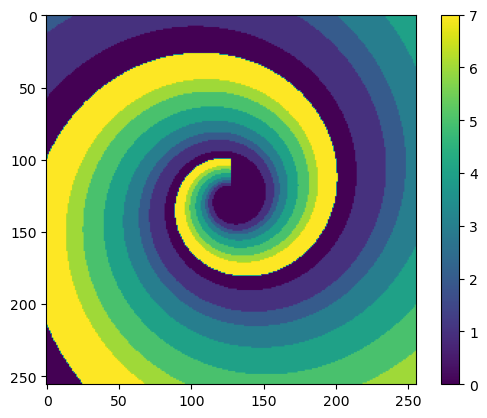

In [6]:
#indexs = get_index_vmap(coords[0].reshape(-1),coords[1].reshape(-1),coords[2].reshape(-1))
indexs = B_generator.indexs.reshape((nx,ny,nz))
plt.imshow(indexs[:,:,32])
plt.colorbar()

In [8]:
%%time
B_field = B_generator.B_field(jf12_params)#.reshape((nx,ny,nz,3))

CPU times: user 3.27 ms, sys: 5.45 ms, total: 8.72 ms
Wall time: 5.33 ms


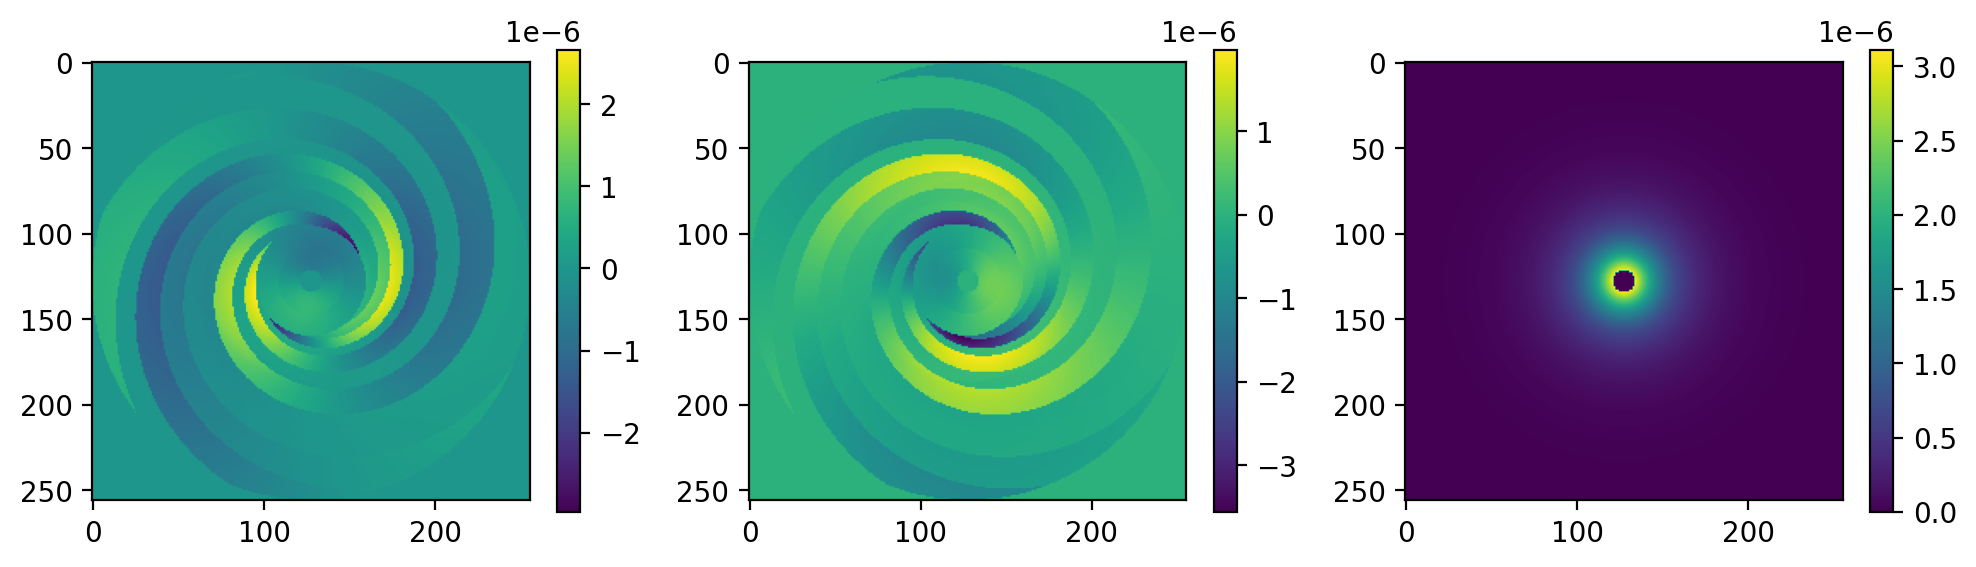

In [9]:
plt.figure(dpi=200,figsize=(12,3))

plt.subplot(131)
plt.imshow(B_field[:,:,32,0])
plt.colorbar()

plt.subplot(132)
plt.imshow(B_field[:,:,32,1])
plt.colorbar()

plt.subplot(133)
plt.imshow(B_field[:,:,32,2])
plt.colorbar()

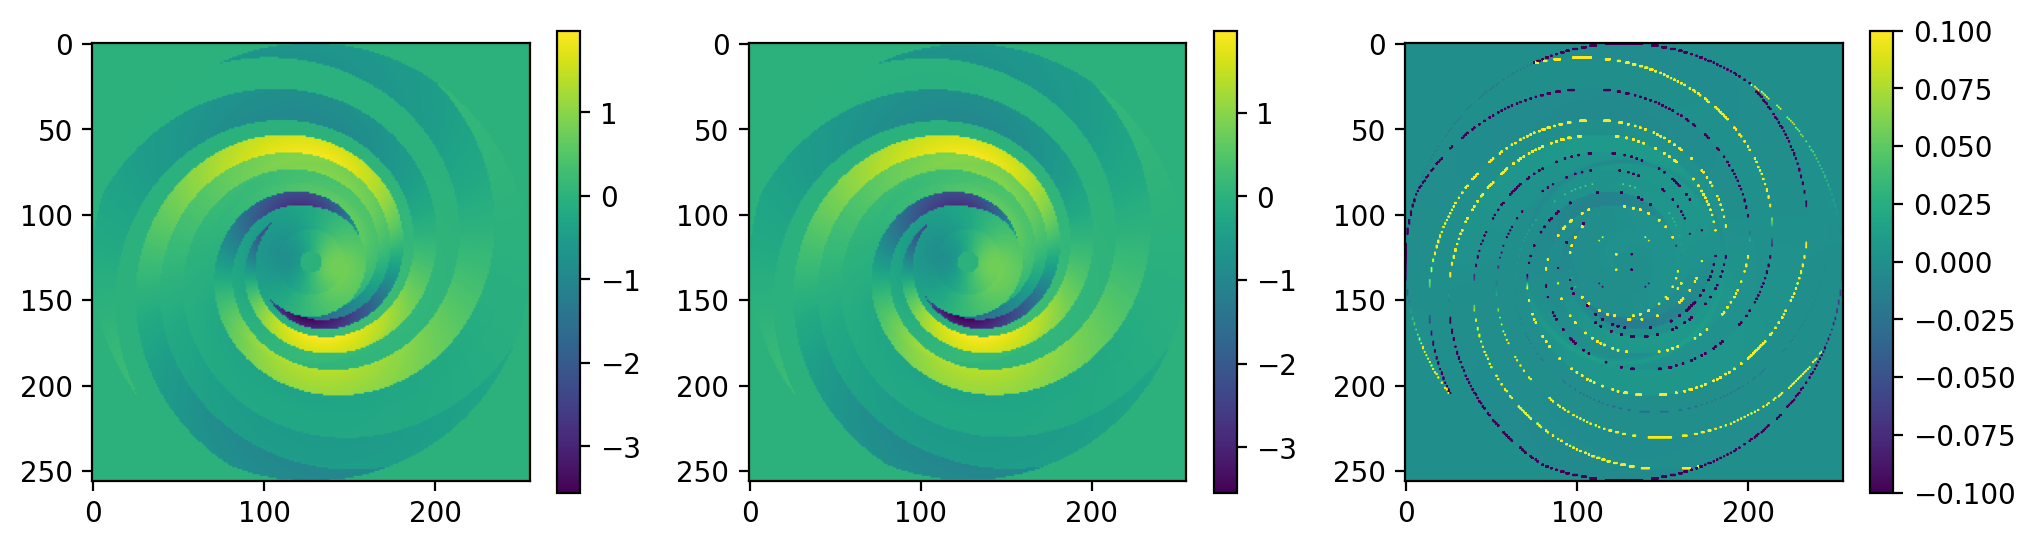

In [11]:
dtype = np.float64 
breg = np.fromfile('../../SyncEmiss/breg.bin', dtype=dtype).reshape((256,256,64,3))*1e6#.reshape((64,4,64,4,16,4,3)).mean(axis = (1,3,5))

plt.figure(dpi=200,figsize=(12,3))

plt.subplot(131)
plt.imshow(B_field[:,:,32,1])
plt.colorbar()

plt.subplot(132)
plt.imshow(breg[:,:,32,1])
plt.colorbar()

plt.subplot(133)
plt.imshow((B_field-breg)[:,:,32,1],vmax=0.1,vmin=-0.1)
plt.colorbar()

In [12]:
def f(jf12_params):
    B_field = B_generator.B_field(jf12_params)
    return B_field.sum()

f_grad = jax.value_and_grad(f)

In [ ]:
%%time
jf12_params = {"b_arm_1":0.1,
               "b_arm_2":3.0,
               "b_arm_3":-0.9,
               "b_arm_4":-0.8,
               "b_arm_5":-2.0,
               "b_arm_6":-4.2,
               "b_arm_7":0.0,
               "b_ring":0.1,
               "h_disk":0.40,
               "w_disk":0.27,
               "bn":1.4,
               "bs":-1.1,
               "rn":9.22,
               "rs":16.7,
               "wh":0.20,
               "z0":5.3,
               "b0_x":4.6,
               "x_theta":49*np.pi/180,
               "rpc_x":4.8,
               "r0_x":2.9}
f_grad(jf12_params)

In [11]:
lsa_params = {"b0":1.2,
               "psi0":27.0*np.pi/180,
               "psi1":0.9*np.pi/180,
               "chi0":25.0*np.pi/180}

B_generator = synax.bfield.B_lsa(coords)

In [13]:
%%time
B_field = B_generator.B_field(lsa_params)

CPU times: user 1.03 ms, sys: 3.86 ms, total: 4.89 ms
Wall time: 3.14 ms


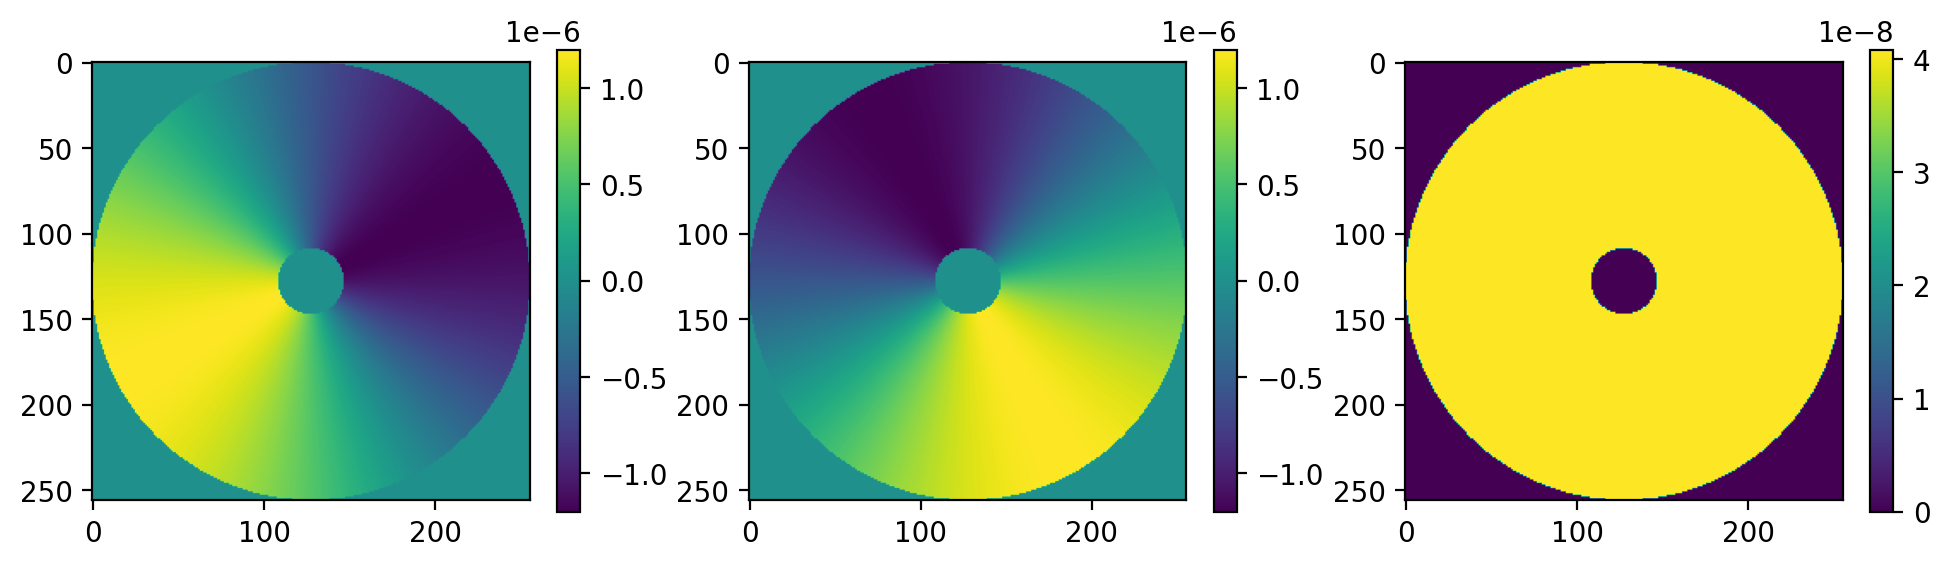

In [14]:
plt.figure(dpi=200,figsize=(12,3))

plt.subplot(131)
plt.imshow(B_field[:,:,32,0])
plt.colorbar()

plt.subplot(132)
plt.imshow(B_field[:,:,32,1])
plt.colorbar()

plt.subplot(133)
plt.imshow(B_field[:,:,32,2])
plt.colorbar()

In [16]:
C_generator = synax.cfield.C_WMAP(coords)

In [17]:
%%time
C_field = C_generator.C_field()

CPU times: user 2.09 s, sys: 837 ms, total: 2.93 s
Wall time: 758 ms


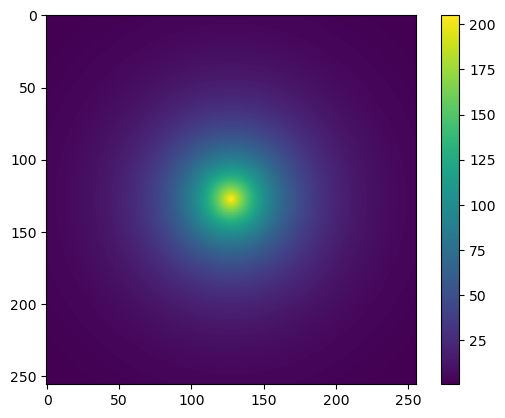

In [18]:
plt.imshow(C_field[:,:,32])
plt.colorbar()

In [33]:
TE_generator = synax.tefield.TE_grid((coords[0]+5.5,coords[1]+5.5,coords[2]),(xs,ys,zs))

In [36]:
%%time
TE_field = TE_generator.TE_field(C_field)

CPU times: user 3.94 ms, sys: 5.16 ms, total: 9.1 ms
Wall time: 7.95 ms


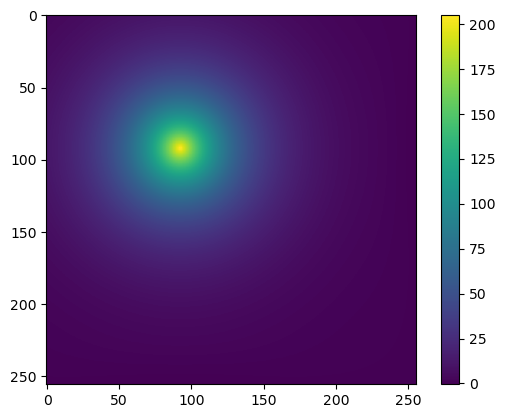

In [35]:
plt.imshow(TE_field[:,:,32])
plt.colorbar()

In [31]:
coords[2].shape

(256, 256, 64)